# 07 - Évaluation du Pipeline Anti-Fuite de Données

Ce notebook démontre le workflow correct pour entraîner et évaluer un modèle de classification de CV **sans fuite de données**.

## Principe Clé

```
❌ MAUVAIS: Preprocessing → Split → Train/Test
✅ BON:     Split → Preprocessing → Train/Test
```

Le split doit être fait sur les données **BRUTES** avant toute transformation.

## 1. Imports et Configuration

In [1]:
import sys
from pathlib import Path

# Ajouter le dossier src au path
PROJECT_ROOT = Path().absolute().parent
sys.path.insert(0, str(PROJECT_ROOT / 'src'))

print(f"Projet: {PROJECT_ROOT}")

Projet: /Users/Apple/Desktop/Projets/Projet_NLPfinal


In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Nos modules
from training.data_splitter import DataSplitter
from training.pipeline_builder import CVClassifierPipelineBuilder
from training.trainer import CVClassifierTrainer
from training.evaluator import PipelineEvaluator

print("✓ Modules importés")

[nltk_data] Downloading package wordnet to /Users/Apple/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/Apple/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


✓ Modules importés


## 2. Chargement des Données Brutes

In [3]:
# Charger le dataset BRUT (non préprocessé)
DATA_PATH = PROJECT_ROOT / 'data' / 'raw' / 'resume_dataset.csv'

df = pd.read_csv(DATA_PATH)

print(f"Dataset chargé: {len(df)} CVs")
print(f"Colonnes: {list(df.columns)}")
df.head(2)

Dataset chargé: 962 CVs
Colonnes: ['Category', 'Resume', 'cleaned_resume']


,Category,Resume,cleaned_resume
0,Data Science,Skills * Programming Languages: Python (pandas...,NaN
1,Data Science,Education Details \r\nMay 2013 to May 2017 B.E...,NaN


In [4]:
# Distribution des catégories
print("Distribution des catégories:")
df['Category'].value_counts()

Distribution des catégories:


Category
Java Developer               84
Testing                      70
DevOps Engineer              55
Python Developer             48
Web Designing                45
HR                           44
Hadoop                       42
Blockchain                   40
ETL Developer                40
Operations Manager           40
Data Science                 40
Sales                        40
Mechanical Engineer          40
Arts                         36
Database                     33
Electrical Engineering       30
Health and fitness           30
PMO                          30
Business Analyst             28
DotNet Developer             28
Automation Testing           26
Network Security Engineer    25
SAP Developer                24
Civil Engineer               24
Advocate                     20
Name: count, dtype: int64

## 3. Split des Données BRUTES (Étape Critique)

⚠️ **C'est ici que tout se joue !**

On sépare les données **AVANT** tout preprocessing pour éviter la fuite d'information.

In [6]:
# Créer le splitter
splitter = DataSplitter(
    test_size=0.2,      # 20% pour le test
    random_state=42,    # Reproductibilité
    stratify=True       # Garder la distribution des classes
)

# Dossier pour sauvegarder les indices
SPLIT_DIR = PROJECT_ROOT / 'data' / 'splits'


print("Création d'un nouveau split...")
train_df, test_df = splitter.split_and_save(df, 'Category', SPLIT_DIR)

Création d'un nouveau split...
Data split completed:
  - Train samples: 769
  - Test samples: 193
  - Indices saved to: /Users/Apple/Desktop/Projets/Projet_NLPfinal/data/splits


In [7]:
# Vérifier le split
print(f"\n📊 Résumé du Split:")
print(f"   Train: {len(train_df)} CVs ({len(train_df)/len(df)*100:.1f}%)")
print(f"   Test:  {len(test_df)} CVs ({len(test_df)/len(df)*100:.1f}%)")
print(f"   Total: {len(df)} CVs")


📊 Résumé du Split:
   Train: 769 CVs (79.9%)
   Test:  193 CVs (20.1%)
   Total: 962 CVs


In [8]:
# Extraire X et y
X_train = train_df['Resume'].values  # Texte BRUT
y_train = train_df['Category'].values

X_test = test_df['Resume'].values    # Texte BRUT
y_test = test_df['Category'].values

print(f"X_train: {len(X_train)} textes bruts")
print(f"X_test:  {len(X_test)} textes bruts")

X_train: 769 textes bruts
X_test:  193 textes bruts


## 4. Encodage des Labels

In [9]:
# Encoder les catégories
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

print(f"Nombre de classes: {len(label_encoder.classes_)}")
print(f"Classes: {list(label_encoder.classes_)}")

Nombre de classes: 25
Classes: ['Advocate', 'Arts', 'Automation Testing', 'Blockchain', 'Business Analyst', 'Civil Engineer', 'Data Science', 'Database', 'DevOps Engineer', 'DotNet Developer', 'ETL Developer', 'Electrical Engineering', 'HR', 'Hadoop', 'Health and fitness', 'Java Developer', 'Mechanical Engineer', 'Network Security Engineer', 'Operations Manager', 'PMO', 'Python Developer', 'SAP Developer', 'Sales', 'Testing', 'Web Designing']


## 5. Construction du Pipeline

Le pipeline encapsule toutes les transformations:

```
Texte Brut → TextCleanerTransformer → TfidfVectorizer → Classifier
```

Ainsi, le TF-IDF est **fit uniquement sur les données d'entraînement**.

In [10]:
# Construire le pipeline
builder = CVClassifierPipelineBuilder(
    classifier_name='random_forest',
    tfidf_params={'max_features': 5000, 'ngram_range': (1, 2)},
    classifier_params={'n_estimators': 200, 'random_state': 42}
)

pipeline = builder.build()

print("Pipeline construit:")
for name, step in pipeline.steps:
    print(f"  → {name}: {type(step).__name__}")

Pipeline construit:
  → text_cleaner: TextCleanerTransformer
  → tfidf: TfidfVectorizer
  → classifier: RandomForestClassifier


## 6. Cross-Validation (sur Train uniquement)

La cross-validation est effectuée **uniquement sur les données d'entraînement**.

Le test set reste complètement isolé.

In [11]:
# Créer le trainer
trainer = CVClassifierTrainer(
    classifier_name='random_forest',
    n_folds=5,
    random_state=42
)

# Lancer la cross-validation
cv_results = trainer.cross_validate(X_train, y_train_encoded)


Starting 5-fold cross-validation...
  - Classifier: random_forest
  - Training samples: 769


[nltk_data] Downloading package wordnet to /Users/Apple/nltk_data...
[nltk_data] Downloading package wordnet to /Users/Apple/nltk_data...
[nltk_data] Downloading package wordnet to /Users/Apple/nltk_data...
[nltk_data] Downloading package wordnet to /Users/Apple/nltk_data...
[nltk_data] Downloading package wordnet to /Users/Apple/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/Apple/nltk_data...
[nltk_data] Downloading package omw-1.4 to /Users/Apple/nltk_data...
[nltk_data] Downloading package omw-1.4 to /Users/Apple/nltk_data...[nltk_data] Downloading package omw-1.4 to /Users/Apple/nltk_data...

[nltk_data] Downloading package omw-1.4 to /Users/Apple/nltk_data...
[nltk_data]   Package omw-1.4 is already up-t


Cross-validation completed in 7.4s

CV Results:
  accuracy:
    CV:    0.9909 (+/- 0.0032)
    Train: 0.9993 (+/- 0.0008)
  f1_macro:
    CV:    0.9894 (+/- 0.0050)
    Train: 0.9991 (+/- 0.0012)
  precision_macro:
    CV:    0.9923 (+/- 0.0034)
    Train: 0.9994 (+/- 0.0007)
  recall_macro:
    CV:    0.9887 (+/- 0.0061)
    Train: 0.9987 (+/- 0.0016)


In [12]:
# Afficher les résultats de CV
print("\n📈 Résultats Cross-Validation (5-fold):")
print("=" * 50)

for metric, scores in cv_results['scores'].items():
    print(f"\n{metric}:")
    print(f"  CV Mean:  {scores['cv_mean']:.4f} (+/- {scores['cv_std']:.4f})")
    print(f"  Train:    {scores['train_mean']:.4f}")


📈 Résultats Cross-Validation (5-fold):

accuracy:
  CV Mean:  0.9909 (+/- 0.0032)
  Train:    0.9993

f1_macro:
  CV Mean:  0.9894 (+/- 0.0050)
  Train:    0.9991

precision_macro:
  CV Mean:  0.9923 (+/- 0.0034)
  Train:    0.9994

recall_macro:
  CV Mean:  0.9887 (+/- 0.0061)
  Train:    0.9987


## 7. Entraînement du Modèle Final

On entraîne maintenant le pipeline sur **tout** le train set.

In [13]:
# Entraîner le modèle final
pipeline = trainer.train(X_train, y_train_encoded, label_encoder)

print(f"\n✓ Modèle entraîné en {trainer.training_time:.2f}s")


Training final model...
  - Classifier: random_forest
  - Training samples: 769
Training completed in 3.2s

✓ Modèle entraîné en 3.21s


## 8. Évaluation Finale sur le Test Set

⚠️ **Cette étape ne doit être faite qu'UNE SEULE FOIS**, à la toute fin.

Le test set n'a jamais été vu pendant l'entraînement ou la validation.

In [14]:
# Créer l'évaluateur
evaluator = PipelineEvaluator(pipeline, label_encoder)

# Évaluer sur le test set
test_results = evaluator.evaluate(X_test, y_test_encoded)


Evaluating on test set (193 samples)...

 TEST SET EVALUATION RESULTS

Overall Metrics:
  Accuracy:  0.9948
  F1 Macro:  0.9957
  Precision: 0.9956
  Recall:    0.9964

Classification Report:
                           precision    recall  f1-score   support

                 Advocate       1.00      1.00      1.00         4
                     Arts       1.00      1.00      1.00         7
       Automation Testing       1.00      1.00      1.00         5
               Blockchain       1.00      1.00      1.00         8
         Business Analyst       1.00      1.00      1.00         6
           Civil Engineer       1.00      1.00      1.00         5
             Data Science       1.00      1.00      1.00         8
                 Database       1.00      1.00      1.00         7
          DevOps Engineer       1.00      0.91      0.95        11
         DotNet Developer       1.00      1.00      1.00         5
            ETL Developer       1.00      1.00      1.00         8
  

In [15]:
# Comparer CV vs Test
comparison = evaluator.compare_with_cv(cv_results)


 CV vs TEST COMPARISON

Accuracy:
  CV:   0.9909
  Test: 0.9948
  Diff: -0.0039

F1 Macro:
  CV:   0.9894
  Test: 0.9957
  Diff: -0.0063

 CV and test scores are consistent - good sign!


## 9. Analyse des Résultats

In [16]:
# Tableau récapitulatif
import pandas as pd

summary = pd.DataFrame({
    'Métrique': ['Accuracy', 'F1 Macro', 'Precision', 'Recall'],
    'CV (mean)': [
        cv_results['scores']['accuracy']['cv_mean'],
        cv_results['scores']['f1_macro']['cv_mean'],
        cv_results['scores']['precision_macro']['cv_mean'],
        cv_results['scores']['recall_macro']['cv_mean']
    ],
    'CV (std)': [
        cv_results['scores']['accuracy']['cv_std'],
        cv_results['scores']['f1_macro']['cv_std'],
        cv_results['scores']['precision_macro']['cv_std'],
        cv_results['scores']['recall_macro']['cv_std']
    ],
    'Test': [
        test_results['metrics']['accuracy'],
        test_results['metrics']['f1_macro'],
        test_results['metrics']['precision_macro'],
        test_results['metrics']['recall_macro']
    ]
})

summary['CV (mean)'] = summary['CV (mean)'].apply(lambda x: f"{x:.4f}")
summary['CV (std)'] = summary['CV (std)'].apply(lambda x: f"±{x:.4f}")
summary['Test'] = summary['Test'].apply(lambda x: f"{x:.4f}")

print("\n📊 Tableau Récapitulatif:")
print("=" * 60)
print(summary.to_string(index=False))


📊 Tableau Récapitulatif:
 Métrique CV (mean) CV (std)   Test
 Accuracy    0.9909  ±0.0032 0.9948
 F1 Macro    0.9894  ±0.0050 0.9957
Precision    0.9923  ±0.0034 0.9956
   Recall    0.9887  ±0.0061 0.9964


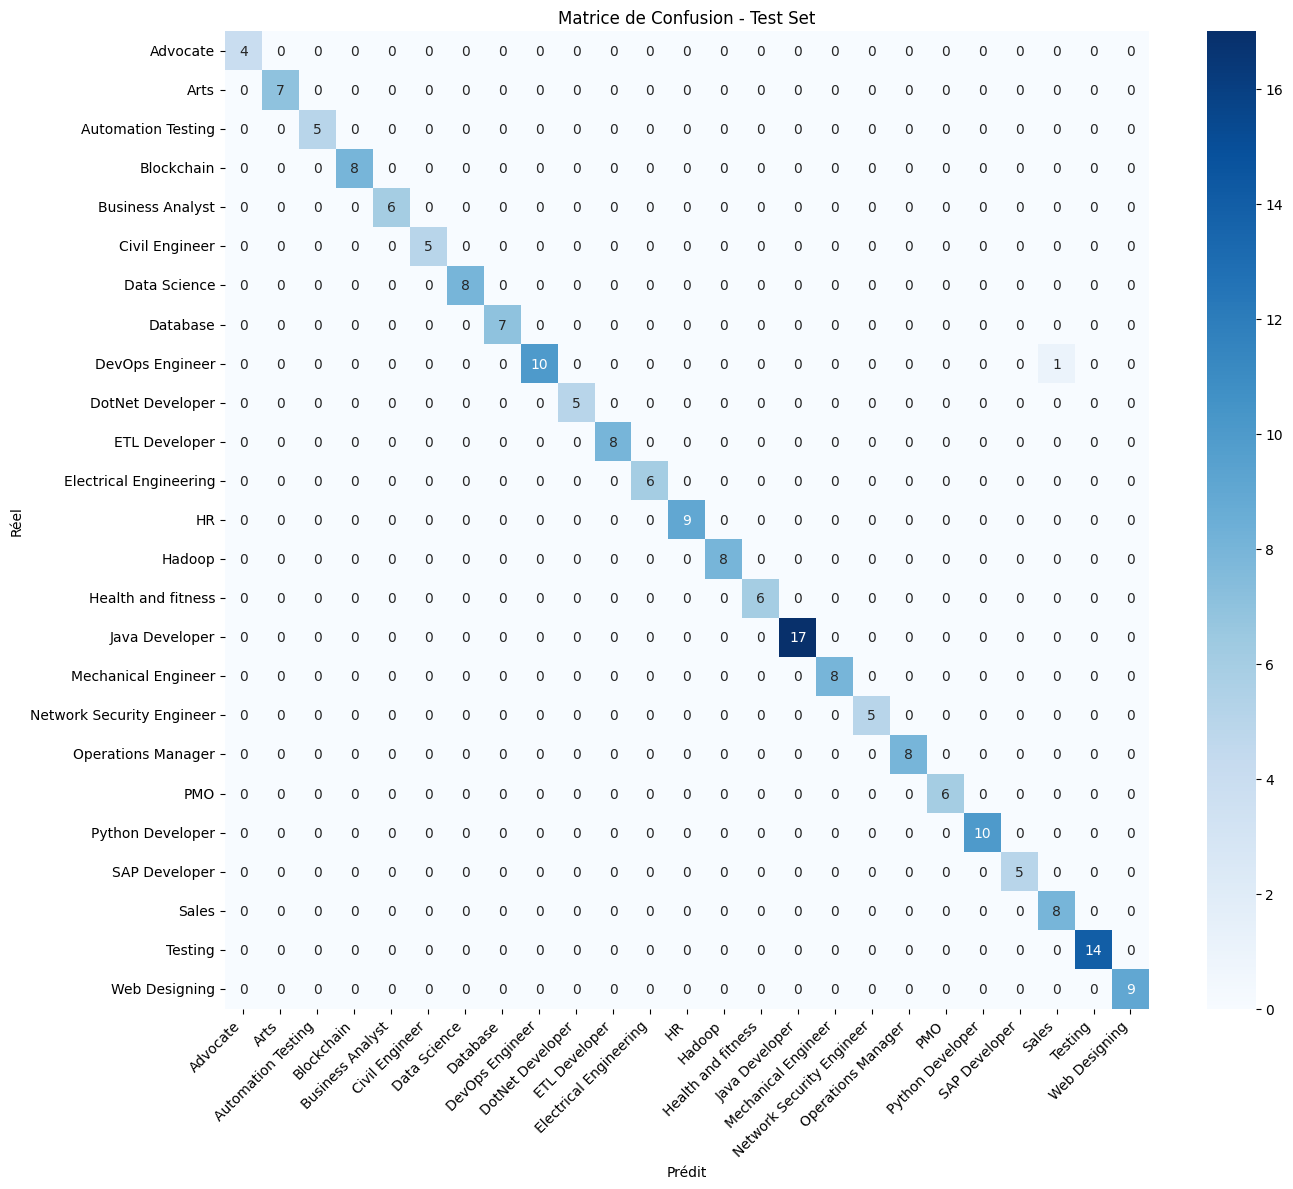

In [17]:
# Visualisation de la matrice de confusion
import matplotlib.pyplot as plt
import seaborn as sns

cm = np.array(test_results['confusion_matrix']['matrix'])
labels = test_results['confusion_matrix']['labels']

plt.figure(figsize=(14, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.title('Matrice de Confusion - Test Set')
plt.xlabel('Prédit')
plt.ylabel('Réel')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## 10. Test avec un Nouveau CV

In [18]:
# Exemple de prédiction
exemple_cv = """
John Doe
Senior Software Developer

EXPERIENCE:
- 5 years of Java development
- Spring Boot, Microservices, REST APIs
- Docker, Kubernetes, AWS
- Agile methodologies, Scrum

SKILLS:
Java, Python, SQL, MongoDB, Git, Jenkins, CI/CD

EDUCATION:
Master's in Computer Science
"""

# Prédiction (le pipeline gère tout: nettoyage + vectorisation + prédiction)
prediction = pipeline.predict([exemple_cv])[0]
probabilities = pipeline.predict_proba([exemple_cv])[0]

# Décoder
category = label_encoder.inverse_transform([prediction])[0]
confidence = probabilities.max()

print(f"Catégorie prédite: {category}")
print(f"Confiance: {confidence:.2%}")

Catégorie prédite: Java Developer
Confiance: 34.52%


In [19]:
# Top 5 catégories
top5_idx = np.argsort(probabilities)[::-1][:5]

print("\nTop 5 catégories:")
for i, idx in enumerate(top5_idx, 1):
    cat = label_encoder.inverse_transform([idx])[0]
    prob = probabilities[idx]
    print(f"  {i}. {cat}: {prob:.2%}")


Top 5 catégories:
  1. Java Developer: 34.52%
  2. Python Developer: 13.59%
  3. HR: 12.73%
  4. Data Science: 6.86%
  5. DotNet Developer: 5.06%


## 11. Conclusion

### Points Clés

1. **Split AVANT preprocessing**: Les données sont séparées en train/test sur le texte BRUT
2. **Pipeline sklearn**: Toutes les transformations sont encapsulées
3. **Cross-validation sur train uniquement**: Le test set reste isolé
4. **Évaluation unique**: Le test set n'est utilisé qu'une seule fois à la fin

### Vérification Anti-Leakage

Si les scores CV et Test sont **proches**, c'est un bon signe qu'il n'y a pas de fuite de données.

- ✅ Différence < 5%: OK
- ⚠️ Différence > 10%: Possible overfitting ou leakage

In [20]:
# Vérification finale
diff = abs(comparison['cv_accuracy'] - comparison['test_accuracy'])

print("\n🔍 Vérification Anti-Leakage:")
print(f"   CV Accuracy:   {comparison['cv_accuracy']:.4f}")
print(f"   Test Accuracy: {comparison['test_accuracy']:.4f}")
print(f"   Différence:    {diff:.4f}")

if diff < 0.05:
    print("\n✅ Pas de fuite de données détectée!")
else:
    print("\n⚠️ Attention: écart important entre CV et Test")


🔍 Vérification Anti-Leakage:
   CV Accuracy:   0.9909
   Test Accuracy: 0.9948
   Différence:    0.0039

✅ Pas de fuite de données détectée!
